In [1]:
from tvDatafeed import TvDatafeed,Interval
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
import json
import numpy as np
import requests
from trade import cross_ema, ichimoku_cloud, macd, collect_mtfssl_pvtdiver
from sklearn import preprocessing
import datetime
# from talib.abstract import EMA, MACD

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
tv = TvDatafeed(username=None,password=None)

you are using nologin method, data you access may be limited


In [112]:
nifty_data=tv.get_hist('TENCENT80','SET',interval=Interval.in_daily,n_bars=10000)

In [3]:
with open(os.path.join(os.getcwd(),'config','list_stock','stock_config.json')) as f:
    json_stock = json.load(f)

In [4]:
def get_data(tv, exchange, name_stock, n_bars):
    return tv.get_hist(name_stock, exchange, interval=Interval.in_daily, n_bars=n_bars)

In [6]:
import talib

In [38]:
def ak_macd_bb(df,length = 10, dev =1, fastlength = 12, slowlength = 26, signallength = 9):
    fastma = talib.EMA(df['close'], fastlength)
    slowma = talib.EMA(df['close'], slowlength)
    macd = fastma - slowma

    stdev = macd.rolling(window=length).std()
    Upper = (stdev * dev + (macd.rolling(window=length).mean()))
    Lower = ((macd.rolling(window=length).mean()) - (stdev * dev))
    return Upper, Lower
    # return upperband, middleband, lowerband
    


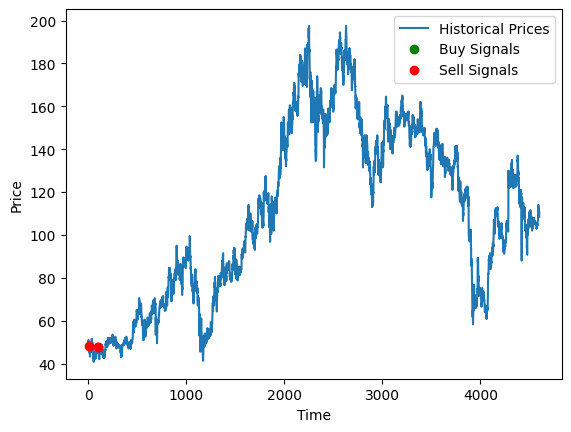

In [58]:
df = get_data(tv, "SET", "SCB", 10000)
df = df.reset_index()

# Define the fast MA period
fast_ma_period = 3

# Define the slow MA period
slow_ma_period = 5

# Define the stochastic oscillator period
stoch_period = 3

# Calculate the fast MA
fast_ma = talib.MA(df['close'], timeperiod=fast_ma_period)

# Calculate the slow MA
slow_ma = talib.MA(df['close'], timeperiod=slow_ma_period)

# Calculate the stochastic oscillator
stoch = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=stoch_period, slowk_period=stoch_period, slowd_period=stoch_period)

# Get the indices of the buy signals
buy_signals = np.where(fast_ma > slow_ma)[0]

# Confirm buy signals with oversold conditions
buy_signals = np.intersect1d(buy_signals, np.where(stoch[0] < 20)[0])

# Get the indices of the sell signals
sell_signals = np.where(fast_ma < slow_ma)[0]

# Confirm sell signals with overbought conditions
sell_signals = np.intersect1d(sell_signals, np.where(stoch[0] > 80)[0])


# Create a line chart of the historical prices
plt.plot(df['close'], label='Historical Prices')

# Create a line chart of the buy signals
plt.plot(buy_signals, df['close'][buy_signals], 'go', label='Buy Signals')

# Create a line chart of the sell signals
plt.plot(sell_signals, df['close'][sell_signals], 'ro', label='Sell Signals')

# Add labels to the chart
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Display the chart
plt.show()

In [76]:
import math
import talib.abstract as ta

In [133]:
def ssl_hybrid(df, len1 = 30, mult=1, type_ssl='EMA'):
    # # Keltner Baseline Channel
    if type_ssl == 'WMA':
        BBMC =  ta.WMA(2 * ta.WMA(df['close'], int(len1 / 2)) - ta.WMA(df['close'], len1), int(np.round(np.sqrt(len1))))
    else:
        BBMC = ta.EMA(df['close'],len1)
    return BBMC


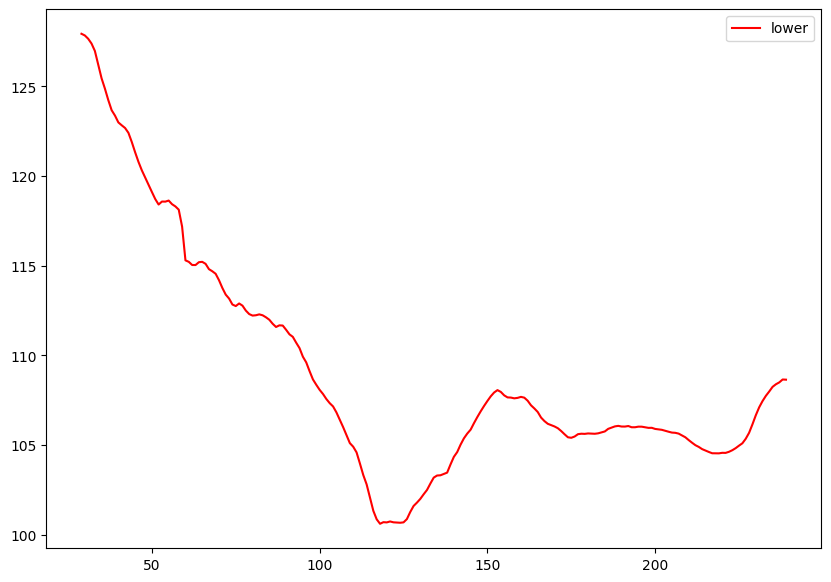

In [145]:

df = get_data(tv, "SET", "SCB", 240)
df = df.reset_index()

# WMA1(df['high'], 60 / 2)
bbmc = ssl_hybrid(df)
# u, l = ak_macd_bb(df)
# u = u.dropna()
# print(u)

# print('close value:',df['close'].iloc[-1] - min(df['close'][-5:]))
# print('result:',df['close'].iloc[-1] - df['close'].iloc[-2])
# pvtup, pvtdown, pvt_osc = pvt_with_divergence(df, 90, 95)
# pvt_osc = normalize_list(pvt_osc)
plt.figure(figsize=(10, 7))
plt.plot(bbmc,'r', label='lower')
# plt.plot(u,'g', label='upper')
# plt.plot(m,'b', label='middle')
plt.legend()
plt.show()
# pvtup = pvtup.dropna()
# pvtdown = pvtdown.dropna()
# pvtup.to_list()[-1]
# type(pvtdown)
# rr = collect_mtfssl_pvtdiver(df,3,20)
# rr


In [144]:
indicator_config = {
    "cross_ema":{
        "low_span": 90,
        "long_span": 95
    },
    "plot_config":{
        "plot": False,
        "n_bar": 60
    }
}
    
# หาวันที่ควรซื้อหุ้นนี้ล่าสุด
df = get_data(tv, "SET", "CPALL", 10000)
result, df = cross_ema(df,"CPALL",**indicator_config)
df = df.reset_index()
df = df.dropna()
df = df.reset_index()
df['bors'] = df['low_df'] - df['long_df']
index_value = df[df['bors'] < 0].iloc[-1:].index.values[0]
df_date_buy = df.iloc[[int(index_value)+1]]
df_date_buy['datetime']
# df['bors'] = df.apply(calc_sum)

# df[df['ema']==0].iloc[-1:]

KeyError: 'low_span'

In [21]:
import datetime

In [22]:
df_date_buy['datetime'].values[0]

numpy.datetime64('2022-12-08T09:00:00.000000000')

In [23]:
# convert from numpy.datetime64 to datetime.datetime
unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
seconds_since_epoch = (df_date_buy['datetime'].values[0] - unix_epoch) / one_second
d = datetime.datetime.utcfromtimestamp(seconds_since_epoch)
d

datetime.datetime(2022, 12, 8, 9, 0)

In [24]:
cc = datetime.datetime.today().date() - d.date()
print(cc.days)

43


In [8]:
from talib.abstract import EMA, MACD

In [9]:
def macd_test(df, namest):
    df['macd_line'], df["signal_line"], _ = MACD(df['close'])
    macd_line = list(df['macd_line'])
    signal_line = list(df["signal_line"])
        
    #     buy
    if macd_line[-1] > signal_line[-1]:
        return 2, df #False
    #     sell
    elif macd_line[-1] < signal_line[-1]:
        return -1, df #True
    return 0, df

In [19]:
v = {'a':12,'b':20,'c':2}
dict(sorted(v.items(), key=lambda item: item[1],reverse=True))


{'b': 20, 'a': 12, 'c': 2}

In [20]:
r= {}
r['a']=1
r['b']=12
r

{'a': 1, 'b': 12}

In [11]:
df = get_data(tv, "SET", "CPALL", 100)
df = df.reset_index()
df = df[df['close'] == min(list(df['close']))] 
df
# df = df.iloc[:,2:]

# c= macd_test(df=df, namest="CPALL")
# ichimoku_cloud(df = df, namest="CPALL")
# macd(df = df, namest="CPALL")
# low_df = EMA(df['close'], 90)
# print(low_df[-1])
# low_df
# long_df = EMA(df['close'], long_span)

,datetime,symbol,open,high,low,close,volume
32,2022-10-07 09:00:00,SET:CPALL,54.5,54.5,53.5,53.75,11873659.0


In [35]:
indicator_config = {
    "ema":[
        {
            "low_span": 90,
            "long_span": 95
        },
        {
            "low_span": 100,
            "long_span": 200
        }
    ]
}
for i in indicator_config['ema']:
    print(i)

{'low_span': 90, 'long_span': 95}
{'low_span': 100, 'long_span': 200}


In [15]:
list(df['macd_line'])[-1]

1.013803161925182

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

list_stock = list()
indicator_config = {
    "ema":[
        {
            "low_span": 90,
            "long_span": 95
        },
        {
            "low_span": 100,
            "long_span": 200
        }
    ]
}

config = {
    "find-min": True,
    "find-max": True
}

# loop key score
dict_stock_name_score = {}
dict_min_value_1 = {}
dict_min_value_2 = {}
dict_remaining_date = {}

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        dict_stock_name_score.update({namest:0})

print('dict_stock_name_score:',dict_stock_name_score)
# find current date
current_date = datetime.datetime.today().date()

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        data = get_data(tv, key_exc, namest, 3000)
        data = data.reset_index()
        
        score_ema = 0
        score_mtfssl_pvtdiver = 0
        for iconfig in indicator_config['ema']:
            result_ema = cross_ema(df = data, namest = namest, **iconfig)

            score_ema += result_ema[0]

            for day in [1,5,10]:
                result_mtfssl_pvtdiver = collect_mtfssl_pvtdiver(data, iconfig['low_span'],iconfig['long_span'], day)
                score_mtfssl_pvtdiver += result_mtfssl_pvtdiver
            
        result_ichimoku = ichimoku_cloud(df = data, namest = namest)
        result_macd = macd(df = data, namest= namest)
        
        if score_mtfssl_pvtdiver > 3:
                score_mtfssl_pvtdiver = 3

        dict_stock_name_score[namest] = dict_stock_name_score[namest] + score_ema + result_ichimoku[0] + result_macd[0] + score_mtfssl_pvtdiver

        # find row with the least close value 
        # df = df[df['close'] == min(list(df['close']))] 

        # find date with the least value in data. do it every month
        list_time = [62, 93]
        for t in list_time:
            data_follow_time = get_data(tv, key_exc, namest, t)
            data_follow_time = data_follow_time.reset_index()

            # find min value in dataframe
            data_cal_number_days = data_follow_time[data_follow_time['close'] == min(list(data_follow_time['close']))]
            # convert timestamp to datetime.date
            if len(data_cal_number_days) > 1:
                data_cal_number_days = data_cal_number_days.iloc[-1,:]
                date_min_value = data_cal_number_days['datetime'].to_pydatetime().date()
            else:
                # convert numpy.datetime64 to datetime
                date_min_value = pd.to_datetime(data_cal_number_days['datetime'].values[0]).to_pydatetime().date()
            # date_min_value = data_cal_number_days['datetime'].to_pydatetime().date()
            remaining_date = current_date - date_min_value
            
            df_min_value = data_follow_time[data_follow_time['close'] == min(list(data_follow_time['close']))]
            df_current_value = data_follow_time.iloc[-2:-1,:]
            if t == 62:
                dict_min_value_1[namest] = df_current_value['close'].values[0] - min(list(data_follow_time['close']))
                dict_remaining_date[namest] = remaining_date.days
            else:
                dict_min_value_2[namest] = df_current_value['close'].values[0] - min(list(data_follow_time['close']))
                dict_remaining_date[namest] = remaining_date.days
    #     break
    # break

# sort data by current close value minus the smallest a value in the past
dict_min_value_1_sort = dict(sorted(dict_min_value_1.items(), key=lambda item: item[1], reverse=True))
dict_min_value_2_sort = dict(sorted(dict_min_value_2.items(), key=lambda item: item[1], reverse=True))
# sort data remaining date
dict_remaining_date_sort = dict(sorted(dict_remaining_date.items(), key=lambda item: item[1], reverse=True))

print('-'*100)
print('dict_min_value_1_sort:',dict_min_value_1_sort)
print('-'*100)

print('result step 1:',dict_stock_name_score)

# loop increase score
for dict_sort_value in [dict_min_value_1_sort, dict_min_value_2_sort, dict_remaining_date_sort]:
    # normalize score
    list_score = [i*100 for i in range(1,len(dict_sort_value)+1)]
    np_score = np.array(list_score)
    normalized_arr = preprocessing.normalize([np_score])


    dict_score = {} 
    for score,(k,v) in zip(normalized_arr.tolist()[0],dict_sort_value.items()):
        dict_score.update({k:score})

    for k,v in dict_score.items():
        dict_stock_name_score[k] = dict_stock_name_score[k] + dict_score[k]


dict_stock_name_score_sort = dict(sorted(dict_stock_name_score.items(), key=lambda item: item[1], reverse=True))
print('-'*100)
for k,v in dict_stock_name_score_sort.items():
    print(k,v)
print('-'*100)

# score date buy last day


# score distance between min close value and close value have to buy



dict_stock_name_score: {'M': 0, 'CRC': 0, 'HMPRO': 0, 'TISCO': 0, 'CPALL': 0, 'KBANK': 0, 'DELTA': 0, 'AOT': 0, 'BANPU': 0, 'BDMS': 0, 'ADVANC': 0, 'PTTEP': 0, 'PTT': 0, 'COM7': 0, 'TOP': 0, 'SCB': 0, 'THG': 0, 'AAPL': 0, 'TSLA': 0, 'NFLX': 0, 'BNTX': 0, 'AMZN': 0, 'MSFT': 0, 'META': 0, 'NVDA': 0, 'GOOGL': 0, 'GOOG': 0, 'PYPL': 0}
----------------------------------------------------------------------------------------------------
dict_min_value_1_sort: {'DELTA': 304.0, 'NFLX': 61.119999999999976, 'META': 47.24000000000001, 'NVDA': 42.99000000000001, 'TSLA': 19.070000000000007, 'MSFT': 17.680000000000007, 'ADVANC': 17.0, 'KBANK': 12.0, 'AMZN': 11.860000000000014, 'GOOG': 10.420000000000002, 'AAPL': 10.250000000000014, 'CPALL': 10.25, 'GOOGL': 9.61999999999999, 'PYPL': 9.200000000000003, 'BNTX': 8.300000000000011, 'SCB': 8.0, 'TISCO': 7.75, 'TOP': 6.25, 'PTTEP': 6.0, 'THG': 4.75, 'CRC': 3.75, 'COM7': 3.25, 'PTT': 2.5, 'BDMS': 2.25, 'M': 2.0, 'AOT': 1.5, 'HMPRO': 0.8000000000000007, 'BANP

In [61]:
df_current_value

,datetime,symbol,open,high,low,close,volume


In [11]:
for k,v in dict_stock_name_score_sort.items():
    print(k,v)

TOP 8.391953200678408
TISCO 8.30485248941654
BDMS 6.631480156648546
PTTEP 6.217751778154671
KBANK 6.174201422523737
HMPRO 5.718580867910415
AOT 5.609704978833079
THG 5.479053911940277
CRC 5.4572787341248095
CPALL 5.174201422523737
DELTA 5.043550355630934
BANPU 3.783906401356816
M 3.718580867910415
PTT 0.5879298010176119
ADVANC 0.08710071126186844
COM7 -0.4991709102442565
AAPL -0.7604730440298617
SCB -2.6733723327679932


In [17]:
dict_min_value_1_sort = {'DELTA': 302.0, 'ADVANC': 17.0, 'KBANK': 11.0, 'AAPL': 10.190000000000012, 'CPALL': 10.0, 'PTTEP': 7.0, 'SCB': 7.0, 'TISCO': 6.75, 'TOP': 5.75, 'THG': 4.75, 'CRC': 3.25, 'COM7': 3.25, 'PTT': 2.5, 'BDMS': 2.25, 'AOT': 2.0, 'M': 1.25, 'HMPRO': 1.0, 'BANPU': 0.09999999999999964}
len(dict_min_value_1_sort)
# for i,(k,v) in enumerate(dict_min_value_1_sort.items()):
#     print(i,k,v)

18

In [71]:
df = get_data(tv, "SET", "CPALL", 100)
df = df.reset_index()
df = df[df['close'] == min(list(df['close']))]
df

,datetime,symbol,open,high,low,close,volume
30,2022-10-07 09:00:00,SET:CPALL,54.5,54.5,53.5,53.75,11873659.0


In [72]:
type(df)

pandas.core.frame.DataFrame

In [64]:
if len(df)>1:
    df = df.iloc[-1,:]

In [87]:
df['datetime'].values[0]

numpy.datetime64('2022-10-07T09:00:00.000000000')

In [123]:
df = get_data(tv, "SET", "CPALL", 3000)
df = df.reset_index()
ssl_d,ssl_u = mtf_ssl(df, 250)

In [130]:
ssl_u.to_list()[-1]

63.262

In [131]:
ssl_d.to_list()[-1]

62.177

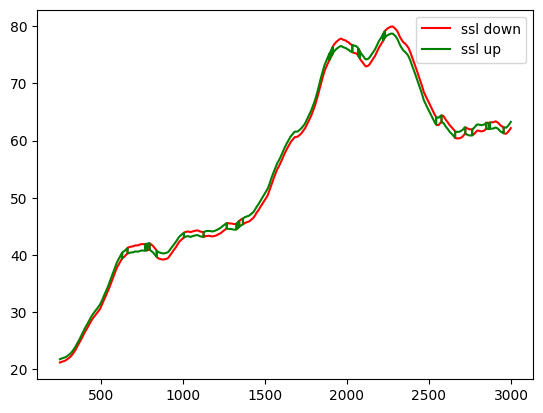

In [126]:
plt.plot(ssl_d,'r', label='ssl down')
plt.plot(ssl_u,'g', label='ssl up')
plt.legend()
plt.show()